# Welcome to StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery

In [ ]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force


%cd
%cd /content/

! pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
! git clone https://github.com/orpatashnik/StyleCLIP

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2
%matplotlib inline


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.0+cu121.with.pypi.cudnn, 2.1.0+rocm5.5, 2.1.0+rocm5.6, 2.1.1, 2.1.1+cpu, 2.1.1+cpu.cxx11.abi, 2.1.1+cu118, 2.1.1+cu121, 2.1.1+cu121.with.pypi.cudnn, 2.1.1+rocm5.5, 2.1.1+rocm5.6, 2.1.2, 2.1.2+cpu, 2.1.2+cpu.cxx11.abi, 2.1.2+cu118, 2.1.2+cu121, 2.1.2+cu121.with.pypi.cudnn, 2.1.2+rocm5.5, 2.1.2+rocm5.6, 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


# Select dataset
If you want to use another dataset, please restart runtime. currently, we only support ffhq.

In [ ]:
dataset_name='ffhq' #@param ['ffhq'] {allow-input: true}
# input dataset name

%cd
%cd /content/StyleCLIP/global_torch/

if not os.path.isfile('./model/'+dataset_name+'.pkl'):
        url='https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/'
        name='stylegan2-'+dataset_name+'-config-f.pkl'
        os.system('wget ' +url+name + '  -P  ./model/')
        os.system('mv ./model/'+name+' ./model/'+dataset_name+'.pkl')


# input prepare data
import clip
from manipulate import Manipulator
from StyleCLIP import GetDt,GetBoundary


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device,jit=False)

network_pkl='./model/'+dataset_name+'.pkl'
device = torch.device('cuda')
M=Manipulator()
M.device=device
G=M.LoadModel(network_pkl,device)
M.G=G
M.SetGParameters()
num_img=100_000
M.GenerateS(num_img=num_img)
M.GetCodeMS()
np.set_printoptions(suppress=True)

file_path='./npy/'+dataset_name+'/'
fs3=np.load(file_path+'fs3.npy')


# Upload an Image
This section can be skipped if you prefer to edit generated image.

In [ ]:
#@title e4e setup
#@ e4e setup
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Downloading...
From: https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
To: /content/encoder4editing/e4e_ffhq_encode.pt
100%|██████████| 1.20G/1.20G [00:13<00:00, 86.6MB/s]


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


--2022-10-30 22:47:36--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  23.6MB/s    in 2.6s    

2022-10-30 22:47:39 (23.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


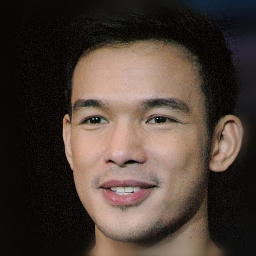

In [ ]:
#@title Align image
image_path = "notebooks/images/input_img.jpg" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

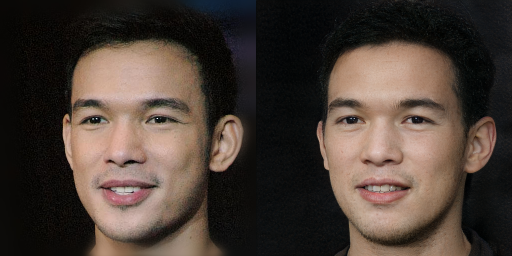

In [ ]:
#@title Invert the image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)